In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('需要拷的数据/packages')
import config


In [2]:
# 读取disclosure.feather文件
file_path = r'C:\Users\ZHOU\Documents\2025CUHK\兴银\需要拷的数据\packages\disclosure.feather'
df = pd.read_feather(file_path)

df.head()

,ts_code,ann_date,end_date,pre_date,actual_date,modify_date
0,000001,2002-03-31,2002-03-31,null,2002-04-23,null
1,000001,2002-09-30,2002-09-30,null,2002-10-25,null
2,000001,2006-09-28,2006-09-30,2006-10-26,2006-10-26,null
3,000001,2006-12-29,2006-12-31,2007-03-22,2007-03-22,null
4,000001,2007-03-30,2007-03-31,2007-04-26,2007-04-26,null


In [3]:
#import tushare as ts
#pro = ts.pro_api()
#
#df = pro.income(ts_code='000001.SZ', start_date='20091231', end_date='20220930', 
#                fields='ts_code,ann_date,f_ann_date,end_date,report_type,comp_type,basic_eps,diluted_eps,total_revenue,revenue,n_income')
##pd.set_option('display.max_rows',None)
#pd.reset_option('display.max_rows')
#df 

## 3.1 公告当天开盘/前收

In [4]:
import numpy as np
import sys
sys.path.append('需要拷的数据/packages')
import config

# 加载股价数据
stock_open, stock_close = config.load_data_local(['stock_open', 'stock_close'])
start_date = '2013-12-31'
end_date = '2022-09-30'
stock_open = stock_open.loc[start_date:end_date]
stock_close = stock_close.loc[start_date:end_date]

In [5]:
# 筛选公告日期
disclosure_clean = df[
    df['actual_date'].notna() &  # 有实际公告日期
    (df['actual_date'] >= '2013-12-31') &  
    (df['actual_date'] <= '2022-09-30')
].copy()

# 向量化转换日期格式
disclosure_clean['actual_date'] = pd.to_datetime(disclosure_clean['actual_date'])

# 向量化去重（同一天同一股票多个公告，保留第一个）
disclosure_unique = disclosure_clean.drop_duplicates(
    subset=['ts_code', 'actual_date'], 
    keep='first'
)

print(f"原始记录数: {len(df)}")
print(f"清洗后记录数: {len(disclosure_clean)}")
print(f"去重后记录数: {len(disclosure_unique)}")
print(f"涉及股票数: {disclosure_unique['ts_code'].nunique()}")

原始记录数: 328222
清洗后记录数: 131173
去重后记录数: 120057
涉及股票数: 5243


In [6]:
disclosure_unique

,ts_code,ann_date,end_date,pre_date,actual_date,modify_date
31,000001,2013-12-31,2013-12-31,2014-03-07,2014-03-07,2014-10-24
32,000001,2014-03-28,2014-03-31,2014-04-24,2014-04-24,null
33,000001,2014-07-01,2014-06-30,2014-08-14,2014-08-14,null
34,000001,2014-09-30,2014-09-30,2014-10-24,2014-10-24,null
35,000001,2014-12-31,2014-12-31,2015-03-13,2015-03-13,null
...,...,...,...,...,...,...
328191,A22045,2021-04-06,2020-12-31,2021-03-16,2021-03-16,2022-03-29
328192,A22045,2021-08-30,2021-06-30,2021-08-31,2021-08-31,null
328193,A22045,2021-10-29,2021-09-30,2021-10-30,2021-10-30,2022-03-29
328194,A22045,2022-04-27,2021-12-31,2022-04-29,2022-04-29,2022-06-17


In [7]:
# 找到前一交易日
# 准备交易日历
trading_dates = pd.DataFrame({'date': stock_close.index}).reset_index()
trading_dates['date_join'] = pd.to_datetime(trading_dates['date'])
trading_dates = trading_dates.sort_values('date').reset_index(drop=True)
trading_dates['date'] = trading_dates['date_join'].shift(1)  # 将date向前移动一位
trading_dates = trading_dates.dropna()  # 去掉最后一行的NaN

print(trading_dates)


      index       date  date_join
1         1 2013-12-31 2014-01-02
2         2 2014-01-02 2014-01-03
3         3 2014-01-03 2014-01-06
4         4 2014-01-06 2014-01-07
5         5 2014-01-07 2014-01-08
...     ...        ...        ...
2128   2128 2022-09-23 2022-09-26
2129   2129 2022-09-26 2022-09-27
2130   2130 2022-09-27 2022-09-28
2131   2131 2022-09-28 2022-09-29
2132   2132 2022-09-29 2022-09-30

[2132 rows x 3 columns]


In [8]:
merged = pd.merge_asof(
    disclosure_unique.sort_values('actual_date'),
    trading_dates,
    left_on='actual_date',
    right_on='date_join',
    direction='backward'
)
merged['actual_date'] = merged['actual_date'].dt.strftime('%Y-%m-%d')
merged['date'] = merged['date'].dt.strftime('%Y-%m-%d')
merged
#merged[merged['ts_code']=='000001'][merged['actual_date']=='2015-03-13']

,ts_code,ann_date,end_date,pre_date,actual_date,modify_date,index,date,date_join
0,000166,null,2013-09-30,null,2014-01-02,null,1,2013-12-31,2014-01-02
1,001324,null,2010-12-31,null,2014-01-10,null,7,2014-01-09,2014-01-10
2,002926,null,2013-06-30,null,2014-01-10,null,7,2014-01-09,2014-01-10
3,600909,null,2013-06-30,null,2014-01-13,null,8,2014-01-10,2014-01-13
4,601878,null,2013-09-30,null,2014-01-14,null,9,2014-01-13,2014-01-14
...,...,...,...,...,...,...,...,...,...
120052,832978,2022-08-31,2022-06-30,2022-09-01,2022-09-01,2022-12-20,2112,2022-08-31,2022-09-01
120053,300038,null,2022-06-30,null,2022-09-01,null,2112,2022-08-31,2022-09-01
120054,688592,2022-08-31,2022-06-30,2022-09-01,2022-09-01,2022-11-26,2112,2022-08-31,2022-09-01
120055,836414,2022-08-31,2022-06-30,2022-09-01,2022-09-01,null,2112,2022-08-31,2022-09-01


In [9]:
merged['prev_close'] = merged.apply(lambda row: stock_close.loc[row['date'], row['ts_code']] 
                                   if row['date'] in stock_close.index and row['ts_code'] in stock_close.columns 
                                   else None, axis=1)

In [10]:
merged['announcement_open'] = merged.apply(lambda row: stock_open.loc[row['actual_date'], row['ts_code']] 
                                          if row['actual_date'] in stock_open.index and row['ts_code'] in stock_open.columns 
                                          else None, axis=1)


In [11]:
merged = merged[(merged['announcement_open'].notna()) & (merged['prev_close'].notna())]
merged['open_to_prev_close'] = merged['announcement_open'] / merged['prev_close']

In [12]:
factor_df = merged.pivot(index='actual_date', columns='ts_code', values='open_to_prev_close')
factor_df

ts_code,000001,000002,000004,000005,000006,000007,000008,000009,000010,000011,000012,000014,000016,000017,000018,000019,000020,000021,000023,000024,...,838670,838924,839167,839680,839725,839729,839946,870204,870299,870436,871245,871396,871553,871642,871857,871970,871981,872925,873169,873223
actual_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-21,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2014-01-22,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2014-01-24,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2014-01-27,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2014-01-28,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-25,nan,nan,1.0053,nan,1.0121,nan,nan,nan,nan,nan,nan,nan,1.0054,nan,nan,nan,nan,nan,1.0019,nan,...,nan,1.0000,nan,1.0191,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.9924,nan
2022-08-26,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.0000,nan,1.0000,nan,0.9984,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,1.0078,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.0078
2022-08-29,nan,nan,nan,nan,nan,nan,nan,nan,0.9914,0.9961,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [13]:
filled_factor_df = factor_df.fillna(method='ffill', limit=120)
filled_factor_df

ts_code,000001,000002,000004,000005,000006,000007,000008,000009,000010,000011,000012,000014,000016,000017,000018,000019,000020,000021,000023,000024,...,838670,838924,839167,839680,839725,839729,839946,870204,870299,870436,871245,871396,871553,871642,871857,871970,871981,872925,873169,873223
actual_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-21,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2014-01-22,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2014-01-24,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2014-01-27,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2014-01-28,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-25,1.0065,1.0027,1.0053,0.9484,1.0121,1.0096,0.9907,0.9976,1.0000,0.9759,1.0181,1.0999,1.0054,1.0000,nan,0.9876,1.0000,0.9934,1.0019,nan,...,0.9691,1.0000,1.0051,1.0191,nan,1.0060,1.0000,0.9541,nan,1.0086,1.0057,1.0000,1.0000,1.0700,1.0090,0.9968,1.0006,0.9988,0.9924,nan
2022-08-26,1.0065,1.0027,1.0053,0.9484,1.0121,1.0096,0.9907,0.9976,1.0000,0.9759,1.0181,1.0999,1.0054,1.0000,nan,1.0000,1.0000,0.9984,1.0019,nan,...,0.9691,1.0000,1.0051,1.0191,nan,1.0060,1.0000,0.9541,1.0078,1.0086,1.0057,1.0000,1.0000,1.0700,1.0090,0.9968,1.0006,0.9988,0.9924,1.0078
2022-08-29,1.0065,1.0027,1.0053,0.9484,1.0121,1.0096,0.9907,0.9976,0.9914,0.9961,1.0181,1.0999,1.0054,1.0000,nan,1.0000,1.0000,0.9984,1.0019,nan,...,0.9691,1.0000,1.0051,1.0191,nan,1.0060,1.0000,0.9541,1.0078,1.0086,1.0057,1.0000,1.0000,1.0700,1.0090,0.9968,1.0006,0.9988,0.9924,1.0078


load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2014   2015    2016   2017   2018   2019   2020   2021   2022  \
年化超额   0.4440 0.1300  0.1409 0.1258 0.1640 0.1200 0.1671 0.0484 0.0288   
波动率     0.2001 0.0578  0.0340 0.0460 0.0557 0.0383 0.0464 0.0527 0.0604   
最大回撤   0.1743 0.0397  0.0127 0.0293 0.0300 0.0259 0.0276 0.0536 0.0796   
夏普率     2.2188 2.2478  4.1458 2.7349 2.9448 3.1310 3.5984 0.9187 0.4766   
收益回撤比 2.5471 3.2724 11.0819 4.2879 5.4713 4.6383 6.0644 0.9036 0.3614   
半波       0.1288 0.0282  0.0156 0.0255 0.0289 0.0211 0.0240 0.0289 0.0305   
半夏普     3.4479 4.6027  9.0514 4.9325 5.6792 5.6787 6.9538 1.6778 0.9443   

             mean  
年化超额   0.1521  
波动率     0.0657  
最大回撤   0.1743  
夏普率     2.3145  
收益回撤比 0.8725  
半波       0.0368  
半夏普     4.1301  


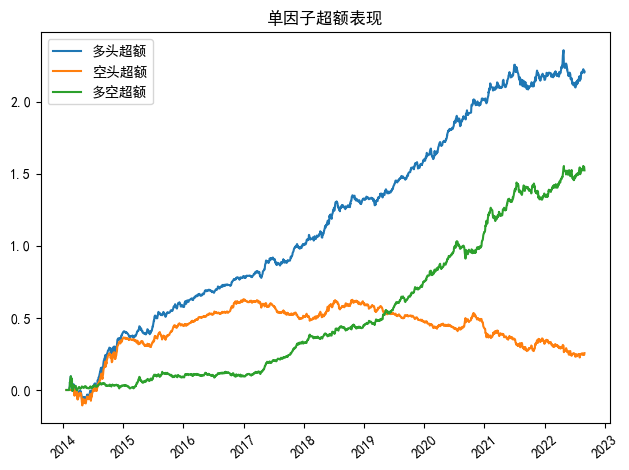

平均单边换手：0.249
年化交易成本:0.009 (未在超额中扣除)


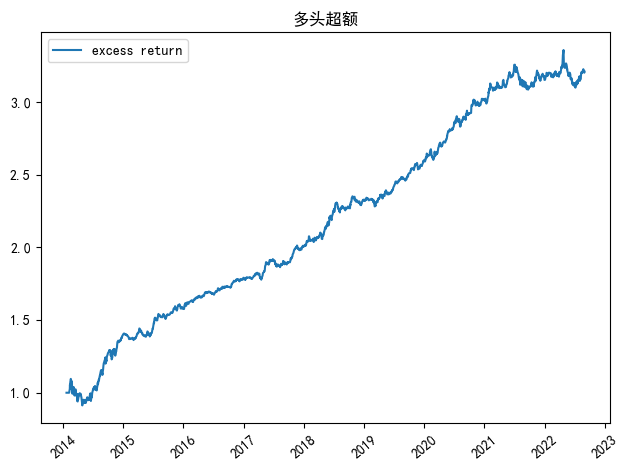

Rank IC: 2.85%
Rank ICIR: 0.95
t值: 9.67
年化收益率: 15.21%
年化波动率: 6.57%
信息比率: 2.31
最大回撤: 17.43%


In [14]:
# 回测
from config import backtest_stand
import numpy as np
pkg_path=r'C:\Users\ZHOU\Documents\2025CUHK\兴银\需要拷的数据\\'
res = backtest_stand(
    filled_factor_df,
    fre='month',
    stock_pool='888888',
    benchmark='b4',
    barra_neutral=True, # 中性化
    top=300,
    localdata_path=pkg_path+'packages/frdata',
    start='2014-01-21',
    end='2022-08-31',
    #equal_weight=True
)
# Rank IC
rank_ic = res['ic']['ic'].mean()
# Rank ICIR
rank_icir = res['ic']['ic'].mean() / res['ic']['ic'].std()
# t值
t_value = res['ic']['ic'].mean() / (res['ic']['ic'].std() / np.sqrt(res['ic']['ic'].count()))
perf = res['多空表现']['多头表现']  
annual_return = perf.loc['年化超额', 'mean']  # 年化收益率
annual_vol = perf.loc['波动率', 'mean']      # 年化波动率
info_ratio = perf.loc['信息比率', 'mean'] if '信息比率' in perf.index else annual_return / annual_vol
#win_rate = perf.loc['胜率', 'mean'] if '胜率' in perf.index else perf.loc['正月数', 'mean'] / perf.loc['总月数', 'mean']
max_drawdown = perf.loc['最大回撤', 'mean']
sharpe_ratio = annual_return / annual_vol
print(f"Rank IC: {rank_ic:.2%}")
print(f"Rank ICIR: {rank_icir:.2f}")
print(f"t值: {t_value:.2f}")
print(f"年化收益率: {annual_return:.2%}")
print(f"年化波动率: {annual_vol:.2%}")
print(f"信息比率: {info_ratio:.2f}")
#print(f"夏普比率: {sharpe_ratio:.2f}")
#print(f"月度胜率: {win_rate:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")


In [15]:
import pickle
with open('frdata/stock_return.pkl', 'rb') as f:
    stock_return = pickle.load(f)  # DataFrame: index=日期, columns=股票代码
stock_return

,000001,000002,000004,000005,000006,000007,000008,000009,000010,000011,000012,000014,000016,000017,000018,000019,000020,000021,000022,000023,...,873726,873806,873833,920002,920008,920016,920019,920029,920060,920066,920082,920088,920098,920099,920106,920108,920111,920116,920118,920128
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-01-05,2.6400,3.8800,3.6500,3.2300,5.0700,4.6300,2.2600,3.7700,1.9400,0.5100,3.0600,1.2200,3.1700,nan,-0.7500,4.9100,3.3300,4.5900,3.3700,4.2000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2009-01-06,6.0800,2.9900,2.9800,3.1300,4.0500,3.2400,3.1000,3.8700,2.0900,3.3200,1.6000,2.2800,3.0800,nan,2.0300,6.9300,2.4200,3.4600,2.6500,3.0200,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2009-01-07,-3.0100,-0.5800,5.0000,-1.1400,-0.7400,-3.1400,1.2900,-0.7000,2.0500,0.7400,-0.3400,0.0000,-1.4900,nan,0.0000,-1.9300,0.7900,0.2200,-1.3900,0.2400,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2009-01-08,-3.9000,0.5800,5.0100,-2.6800,-1.8700,3.5400,2.5400,-3.2900,1.2800,0.2500,0.1100,-5.5100,-2.7300,nan,-0.5000,0.7100,-3.9100,-2.4500,-3.5200,-2.4400,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2009-01-09,2.6000,-0.1400,3.8200,4.3300,0.9500,0.0000,1.8600,3.6400,0.7200,2.4500,2.1400,4.1700,2.4900,nan,1.0000,4.0800,1.6300,2.2800,1.5600,3.7500,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-09,-0.1848,3.8235,2.5404,nan,3.6778,2.4209,5.0909,1.3316,2.9167,4.1278,0.6303,2.4705,9.8958,0.9124,nan,-3.5230,2.0896,3.7618,nan,nan,...,11.5921,11.5689,8.4118,29.9939,23.4721,6.7132,7.2408,2.3855,7.5608,6.2464,11.8372,8.0993,14.8879,7.7547,8.2217,6.7058,8.3439,21.4906,8.4669,7.2613
2025-04-10,0.9259,1.9830,2.7027,nan,3.0405,5.8182,5.8824,1.5769,4.0486,2.0460,0.6263,9.9581,9.9526,2.8933,nan,1.6854,5.3606,0.9063,nan,nan,...,30.0000,1.9886,4.9919,10.8327,0.4304,3.5948,2.7621,-0.8002,4.1681,2.5772,2.8115,2.8151,3.9044,3.5983,0.1688,3.7156,3.0727,0.4801,3.7135,3.8832
2025-04-11,-0.0917,-1.6667,0.3289,nan,3.1148,1.7182,-2.9412,0.6468,0.0000,-1.1278,0.0000,0.0000,9.9138,1.9332,nan,-4.4199,1.1101,2.8144,nan,nan,...,1.3926,0.9749,-0.3618,1.9102,0.8333,-1.5379,0.4480,-3.6418,2.1702,-0.9683,-0.8043,0.5476,-0.5507,-0.5368,2.4944,0.5307,0.0377,7.2308,0.9865,0.2646


In [16]:
daily_market_return = stock_return.mean(axis=1, skipna=True)
daily_market_return

index
2009-01-05    4.3450
2009-01-06    3.5600
2009-01-07    0.5560
2009-01-08   -2.1537
2009-01-09    2.9032
               ...  
2025-04-09    2.8773
2025-04-10    2.8511
2025-04-11    0.8932
2025-04-14    1.8775
2025-04-15    0.0763
Length: 3954, dtype: float64

In [17]:
market_return_aligned = daily_market_return.reindex(filled_factor_df.index)
excess_factor_df = filled_factor_df.sub(market_return_aligned, axis=0)
excess_factor_df

ts_code,000001,000002,000004,000005,000006,000007,000008,000009,000010,000011,000012,000014,000016,000017,000018,000019,000020,000021,000023,000024,...,838670,838924,839167,839680,839725,839729,839946,870204,870299,870436,871245,871396,871553,871642,871857,871970,871981,872925,873169,873223
actual_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-21,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2014-01-22,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2014-01-24,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2014-01-27,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2014-01-28,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-25,1.4032,1.3994,1.4020,1.3451,1.4089,1.4063,1.3875,1.3943,1.3968,1.3726,1.4149,1.4967,1.4021,1.3968,nan,1.3844,1.3968,1.3902,1.3986,nan,...,1.3659,1.3968,1.4018,1.4159,nan,1.4028,1.3968,1.3509,nan,1.4053,1.4025,1.3968,1.3968,1.4668,1.4058,1.3935,1.3973,1.3955,1.3891,nan
2022-08-26,1.5493,1.5455,1.5481,1.4912,1.5550,1.5524,1.5336,1.5404,1.5428,1.5187,1.5609,1.6427,1.5482,1.5428,nan,1.5428,1.5428,1.5413,1.5447,nan,...,1.5119,1.5428,1.5479,1.5619,nan,1.5488,1.5428,1.4969,1.5506,1.5514,1.5485,1.5428,1.5428,1.6129,1.5518,1.5396,1.5434,1.5416,1.5352,1.5506
2022-08-29,0.2175,0.2137,0.2163,0.1594,0.2232,0.2206,0.2018,0.2086,0.2024,0.2071,0.2292,0.3110,0.2164,0.2111,nan,0.2111,0.2111,0.2095,0.2129,nan,...,0.1802,0.2111,0.2161,0.2302,nan,0.2171,0.2111,0.1652,0.2189,0.2196,0.2168,0.2111,0.2111,0.2811,0.2201,0.2078,0.2116,0.2098,0.2034,0.2189


load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2014   2015    2016   2017   2018   2019   2020   2021   2022  \
年化超额   0.4440 0.1300  0.1409 0.1258 0.1640 0.1200 0.1671 0.0484 0.0288   
波动率     0.2001 0.0578  0.0340 0.0460 0.0557 0.0383 0.0464 0.0527 0.0604   
最大回撤   0.1743 0.0397  0.0127 0.0293 0.0300 0.0259 0.0276 0.0536 0.0796   
夏普率     2.2188 2.2478  4.1458 2.7349 2.9448 3.1310 3.5984 0.9187 0.4766   
收益回撤比 2.5471 3.2724 11.0819 4.2879 5.4713 4.6383 6.0644 0.9036 0.3614   
半波       0.1288 0.0282  0.0156 0.0255 0.0289 0.0211 0.0240 0.0289 0.0305   
半夏普     3.4479 4.6027  9.0514 4.9325 5.6792 5.6787 6.9538 1.6778 0.9443   

             mean  
年化超额   0.1521  
波动率     0.0657  
最大回撤   0.1743  
夏普率     2.3145  
收益回撤比 0.8725  
半波       0.0368  
半夏普     4.1301  


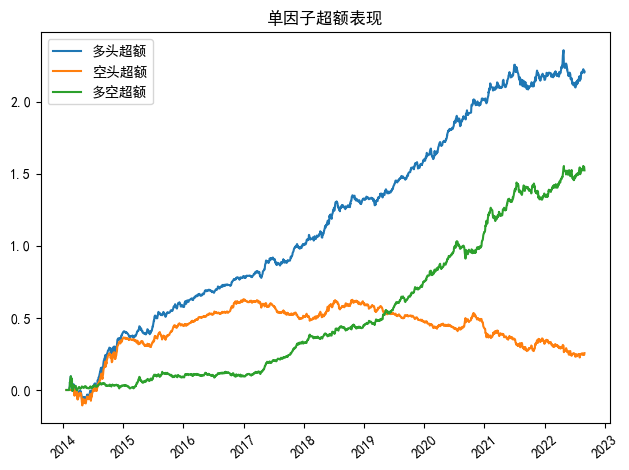

平均单边换手：0.249
年化交易成本:0.009 (未在超额中扣除)


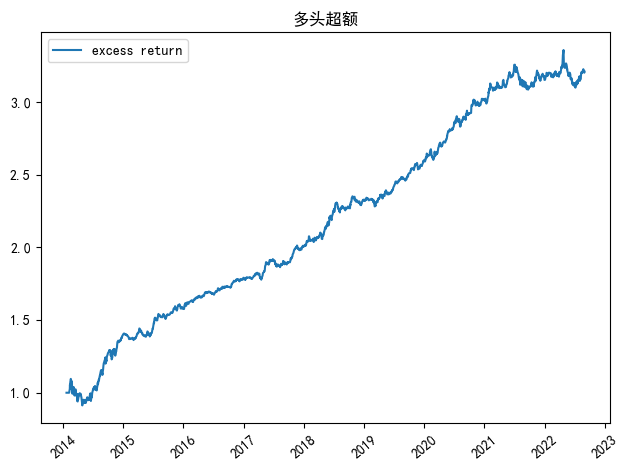

Rank IC: 2.85%
Rank ICIR: 0.95
t值: 9.67
年化收益率: 15.21%
年化波动率: 6.57%
信息比率: 2.31
最大回撤: 17.43%


In [18]:
# 回测
from config import backtest_stand
import numpy as np
pkg_path=r'C:\Users\ZHOU\Documents\2025CUHK\兴银\需要拷的数据\\'
res = backtest_stand(
    excess_factor_df,
    fre='month',
    stock_pool='888888',
    benchmark='b4',
    barra_neutral=True, # 中性化
    top=300,
    localdata_path=pkg_path+'packages/frdata',
    start='2014-01-21',
    end='2022-08-31',
    #equal_weight=True
)
# Rank IC
rank_ic = res['ic']['ic'].mean()
# Rank ICIR
rank_icir = res['ic']['ic'].mean() / res['ic']['ic'].std()
# t值
t_value = res['ic']['ic'].mean() / (res['ic']['ic'].std() / np.sqrt(res['ic']['ic'].count()))
perf = res['多空表现']['多头表现']  
annual_return = perf.loc['年化超额', 'mean']  # 年化收益率
annual_vol = perf.loc['波动率', 'mean']      # 年化波动率
info_ratio = perf.loc['信息比率', 'mean'] if '信息比率' in perf.index else annual_return / annual_vol
#win_rate = perf.loc['胜率', 'mean'] if '胜率' in perf.index else perf.loc['正月数', 'mean'] / perf.loc['总月数', 'mean']
max_drawdown = perf.loc['最大回撤', 'mean']
sharpe_ratio = annual_return / annual_vol
print(f"Rank IC: {rank_ic:.2%}")
print(f"Rank ICIR: {rank_icir:.2f}")
print(f"t值: {t_value:.2f}")
print(f"年化收益率: {annual_return:.2%}")
print(f"年化波动率: {annual_vol:.2%}")
print(f"信息比率: {info_ratio:.2f}")
#print(f"夏普比率: {sharpe_ratio:.2f}")
#print(f"月度胜率: {win_rate:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")
